In [1]:
# Import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from shapely.geometry import Point
from shapely.geometry import shape
import seaborn as sns
from datetime import datetime
import os
from zipfile import ZipFile
import random
import networkx as nx
from datetime import datetime, timedelta

In [2]:
## ================================================== Read file and data preprocess ==========================================##

In [3]:
# read station information
station_info = pd.read_csv('Data/station_info.csv')
station_info['geometry'] = station_info[['longitude', 'latitude']].values.tolist()
station_info['geometry'] = station_info['geometry'].apply(Point)

# select those bike stations within DC 
DC_road_info = gpd.read_file('Data/Shapefile/Roads.geojson')
DC_boundary = gpd.read_file('Data/Shapefile/Washington_DC_Boundary.geojson')
DC_station_index = []
for i in range (len(station_info)):
    if station_info.geometry[i].within(DC_boundary.geometry[0]):
        DC_station_index.append(i)
station_info = station_info.loc[DC_station_index]

# read bikeshare data in 2020.03
sharingbikedata = pd.read_csv('Data/202003-capitalbikeshare-tripdata.csv')
sharingbikedata = sharingbikedata[sharingbikedata['Start station number'].isin(station_info.station_id.unique())]
sharingbikedata = sharingbikedata[sharingbikedata['End station number'].isin(station_info.station_id.unique())]

# replace old station id with new station id

# add start_station_info into sharingbikedata
sharingbikedata = sharingbikedata.merge(station_info,
                                        how = 'left',
                                       left_on = 'Start station number',
                                       right_on = 'station_id')
sharingbikedata = sharingbikedata.rename(columns = {"latitude": "start_lat",
                                                   "longitude": "start_lon",
                                                   "geometry": "start_geo"})

# add end_station_info into sharingbikedata
sharingbikedata = sharingbikedata.merge(station_info,
                                        how = 'left',
                                       left_on = 'End station number',
                                       right_on = 'station_id')
sharingbikedata = sharingbikedata.rename(columns = {"latitude": "end_lat",
                                                   "longitude": "end_lon",
                                                   "geometry": "end_geo"})

sharingbikedata = sharingbikedata.drop(columns = {"station_id_x", "station_id_y"}, axis = 1)
sharingbikedata.head()

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type,start_lat,start_lon,start_geo,end_lat,end_lon,end_geo
0,1596,2020-03-01 00:01:16,2020-03-01 00:27:52,31646,Maine Ave & 9th St SW,31509,New Jersey Ave & R St NW,W24217,Member,38.880438,-77.025233,POINT (-77.02523289525229 38.88043753070527),38.912664,-77.017661,POINT (-77.0176608955109 38.91266406524684)
1,448,2020-03-01 00:02:04,2020-03-01 00:09:32,31646,Maine Ave & 9th St SW,31272,Washington & Independence Ave SW/HHS,W21897,Member,38.880438,-77.025233,POINT (-77.02523289525229 38.88043753070527),38.886982,-77.013768,POINT (-77.0137679945496 38.886981582202)
2,283,2020-03-01 00:03:45,2020-03-01 00:08:28,31224,18th & L St NW,31200,Massachusetts Ave & Dupont Circle NW,W21703,Member,38.903736,-77.042452,POINT (-77.04245170058888 38.90373645678299),38.910103,-77.044394,POINT (-77.04439437680891 38.91010276338776)
3,642,2020-03-01 00:05:49,2020-03-01 00:16:31,31603,1st & M St NE,31611,13th & H St NE,78571,Member,38.905691,-77.005487,POINT (-77.00548701284578 38.90569127748272),38.900433,-76.988250,POINT (-76.98824960583481 38.90043344854352)
4,347,2020-03-01 00:06:53,2020-03-01 00:12:40,31101,14th & V St NW,31114,18th St & Wyoming Ave NW,W23425,Member,38.917766,-77.032083,POINT (-77.0320827701709 38.91776604521078),38.918805,-77.041569,POINT (-77.04156933406961 38.91880522982117)


In [4]:
# compute travel distance (km)
origin_geo = gpd.GeoDataFrame({'geometry': sharingbikedata.start_geo}, crs='EPSG:4326').to_crs('EPSG:5234')
destination_geo = gpd.GeoDataFrame({'geometry': sharingbikedata.end_geo}, crs='EPSG:4326').to_crs('EPSG:5234')
sharingbikedata['Distance'] = origin_geo.distance(destination_geo)/1000

# compute travel time (min)
sharingbikedata['Duration'] = sharingbikedata['Duration']/60

sharingbikedata.head()

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type,start_lat,start_lon,start_geo,end_lat,end_lon,end_geo,Distance
0,26.600000,2020-03-01 00:01:16,2020-03-01 00:27:52,31646,Maine Ave & 9th St SW,31509,New Jersey Ave & R St NW,W24217,Member,38.880438,-77.025233,POINT (-77.02523289525229 38.88043753070527),38.912664,-77.017661,POINT (-77.0176608955109 38.91266406524684),3.805322
1,7.466667,2020-03-01 00:02:04,2020-03-01 00:09:32,31646,Maine Ave & 9th St SW,31272,Washington & Independence Ave SW/HHS,W21897,Member,38.880438,-77.025233,POINT (-77.02523289525229 38.88043753070527),38.886982,-77.013768,POINT (-77.0137679945496 38.886981582202),1.288720
2,4.716667,2020-03-01 00:03:45,2020-03-01 00:08:28,31224,18th & L St NW,31200,Massachusetts Ave & Dupont Circle NW,W21703,Member,38.903736,-77.042452,POINT (-77.04245170058888 38.90373645678299),38.910103,-77.044394,POINT (-77.04439437680891 38.91010276338776),0.760024
3,10.700000,2020-03-01 00:05:49,2020-03-01 00:16:31,31603,1st & M St NE,31611,13th & H St NE,78571,Member,38.905691,-77.005487,POINT (-77.00548701284578 38.90569127748272),38.900433,-76.988250,POINT (-76.98824960583481 38.90043344854352),1.679400
4,5.783333,2020-03-01 00:06:53,2020-03-01 00:12:40,31101,14th & V St NW,31114,18th St & Wyoming Ave NW,W23425,Member,38.917766,-77.032083,POINT (-77.0320827701709 38.91776604521078),38.918805,-77.041569,POINT (-77.04156933406961 38.91880522982117),0.869058


In [5]:
sharingbikedata[["Duration", "Distance"]].describe()

,Duration,Distance
count,133653.000000,133653.000000
mean,17.593224,1.854632
std,33.253059,1.252402
min,1.000000,0.000000
25%,6.850000,0.948794
50%,11.700000,1.601995
75%,19.533333,2.553047
max,1436.700000,11.530046


In [6]:
## add hour and day
sharingbikedata['Start date'] = pd.to_datetime(sharingbikedata['Start date'])
sharingbikedata['start_day'] = sharingbikedata["Start date"].dt.day
sharingbikedata['start_hour'] = sharingbikedata["Start date"].dt.hour
sharingbikedata['start_min'] = sharingbikedata["Start date"].dt.minute

sharingbikedata['End date'] = pd.to_datetime(sharingbikedata['End date'])
sharingbikedata['end_day'] = sharingbikedata["End date"].dt.day
sharingbikedata['end_hour'] = sharingbikedata["End date"].dt.hour
sharingbikedata['end_min'] = sharingbikedata["End date"].dt.minute

sharingbikedata.head()

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type,start_lat,...,end_lat,end_lon,end_geo,Distance,start_day,start_hour,start_min,end_day,end_hour,end_min
0,26.600000,2020-03-01 00:01:16,2020-03-01 00:27:52,31646,Maine Ave & 9th St SW,31509,New Jersey Ave & R St NW,W24217,Member,38.880438,...,38.912664,-77.017661,POINT (-77.0176608955109 38.91266406524684),3.805322,1,0,1,1,0,27
1,7.466667,2020-03-01 00:02:04,2020-03-01 00:09:32,31646,Maine Ave & 9th St SW,31272,Washington & Independence Ave SW/HHS,W21897,Member,38.880438,...,38.886982,-77.013768,POINT (-77.0137679945496 38.886981582202),1.288720,1,0,2,1,0,9
2,4.716667,2020-03-01 00:03:45,2020-03-01 00:08:28,31224,18th & L St NW,31200,Massachusetts Ave & Dupont Circle NW,W21703,Member,38.903736,...,38.910103,-77.044394,POINT (-77.04439437680891 38.91010276338776),0.760024,1,0,3,1,0,8
3,10.700000,2020-03-01 00:05:49,2020-03-01 00:16:31,31603,1st & M St NE,31611,13th & H St NE,78571,Member,38.905691,...,38.900433,-76.988250,POINT (-76.98824960583481 38.90043344854352),1.679400,1,0,5,1,0,16
4,5.783333,2020-03-01 00:06:53,2020-03-01 00:12:40,31101,14th & V St NW,31114,18th St & Wyoming Ave NW,W23425,Member,38.917766,...,38.918805,-77.041569,POINT (-77.04156933406961 38.91880522982117),0.869058,1,0,6,1,0,12


In [7]:
## ================================================ Read Station_info information =========================================##

In [8]:
# Read station_info with attributes
station_info = pd.read_csv('Data/station_info_attribute.csv')
station_info['geometry'] = station_info[["longitude", "latitude"]].values.tolist()
station_info['geometry'] = station_info['geometry'].apply(Point)
station_info = gpd.GeoDataFrame(station_info)
station_info['Bike_Stop'] = 'Bike_Stop' 
station_info = station_info.drop(columns = {'start_ridership', 'end_ridership'}, axis = 1)
print(len(station_info))
station_info.head()

352


,station_id,latitude,longitude,geometry,TRACTCE,pop_den,male_ratio,housing_unit_den,LU_diversity,bike_density,Bike_Stop
0,31100.0,38.900289,-77.042902,POINT (-77.04290 38.90029),10700,0.001615,0.467361,0.001530,1.410208,0.519472,Bike_Stop
1,31101.0,38.917766,-77.032083,POINT (-77.03208 38.91777),4300,0.014014,0.440458,0.010089,2.515274,0.406192,Bike_Stop
2,31102.0,38.929463,-77.027821,POINT (-77.02782 38.92946),3000,0.013170,0.409156,0.007601,1.914395,0.229339,Bike_Stop
3,31104.0,38.922865,-77.042517,POINT (-77.04252 38.92286),3901,0.017918,0.405918,0.014953,2.041013,0.249042,Bike_Stop
4,31105.0,38.926792,-77.032203,POINT (-77.03220 38.92679),3000,0.013170,0.409156,0.007601,1.914395,0.229339,Bike_Stop


In [9]:
station_info.describe()

,station_id,latitude,longitude,TRACTCE,pop_den,male_ratio,housing_unit_den,LU_diversity,bike_density
count,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000
mean,31435.789773,38.904489,-77.018213,58935.784091,0.005540,0.499546,0.003612,1.946706,0.290042
std,229.379831,0.026256,0.031257,220346.598151,0.004546,0.142671,0.003703,0.434835,0.224606
min,31100.000000,38.819090,-77.103666,102.000000,0.000002,0.293966,0.000000,0.610679,0.001060
25%,31250.750000,38.890459,-77.038412,4001.750000,0.002390,0.430264,0.001513,1.644312,0.131347
50%,31405.500000,38.902625,-77.021647,7201.500000,0.004013,0.469341,0.002401,1.928141,0.246447
75%,31634.250000,38.919032,-76.998009,9653.250000,0.008153,0.530026,0.004500,2.240942,0.405845
max,32901.000000,38.975219,-76.913580,980000.000000,0.026697,1.000000,0.027061,2.809673,1.000000


In [10]:
## ================================================== read GTFS data ================================================##

In [11]:
# extract stop_id information (useful for the next step)
from zipfile import ZipFile
 
# Open the zip file in read-only mode.
archive = ZipFile("Data/GTFS/gtfs_20200301.zip", "r")
stops_info = pd.read_csv(archive.open("stops.txt"))
stops_info['geometry'] = stops_info[['stop_lon', 'stop_lat']].values.tolist()
stops_info['geometry'] = stops_info['geometry'].apply(Point)

# select those transit stops within Washington D.C.
DC_stop_index = []
for i in range (len(stops_info)):
    if stops_info.geometry[i].within(DC_boundary.geometry[0]):
        DC_stop_index.append(i)
stops_info = stops_info.loc[DC_stop_index]
stops_info.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,geometry
0,1,1002500,WISCONSIN AVE NW & RIVER RD NW,NaN,38.949019,-77.080369,8,POINT (-77.080369 38.949019)
25,42,1000647,51ST ST SE & D ST SE,NaN,38.883825,-76.928735,7,POINT (-76.928735 38.883825)
26,46,1003307,51ST ST NE & BANKS PL NE,NaN,38.893961,-76.928381,7,POINT (-76.928381 38.893961)
42,96,1002478,WISCONSIN AVE NW & ALBEMARLE ST NW,NaN,38.947750,-77.079402,9,POINT (-77.079402 38.94775)
74,134,1003107,ALABAMA AVE & 12TH ST,NaN,38.844214,-76.990800,5,POINT (-76.99079999999999 38.844214)


In [12]:
# Open the zip file in read-only mode.

import warnings
warnings.filterwarnings('ignore')

def update_datetime(dt_str):
    date_str, time_str = dt_str.split(' ')
    year, month, day = [int(x) for x in date_str.split('-')]
    hour, minute, second = [int(x) for x in time_str.split(':')]
    dt = datetime(year, month, day, hour % 24, minute, second) + timedelta(days = (hour // 24))
    updated_dt_str = dt.strftime('%Y-%m-%d %H:%M:%S')
    return updated_dt_str

date_list = ['2020-03-01 ', '2020-03-02 ', '2020-03-03 ', '2020-03-04 ', '2020-03-05 ', '2020-03-06 ', '2020-03-07 ', '2020-03-08 ',
             '2020-03-09 ', '2020-03-10 ', '2020-03-11 ', '2020-03-12 ', '2020-03-13 ', '2020-03-14 ', '2020-03-15 ', '2020-03-16 ',
             '2020-03-17 ', '2020-03-18 ', '2020-03-19 ', '2020-03-20 ', '2020-03-21 ', '2020-03-22 ', '2020-03-23 ', '2020-03-24 ',
             '2020-03-25 ', '2020-03-26 ', '2020-03-27 ', '2020-03-28 ', '2020-03-29 ', '2020-03-30 ', '2020-03-31 ']

directory = "Data/GTFS/"
file_paths = []
# crawling through directory and subdirectories
for root, directories, files in os.walk(directory):
    for filename in files:
        # join the two strings in order to form the full filepath.
        filepath = os.path.join(root, filename)
        file_paths.append(filepath)

transit_stops_march = []

for i in range (len(file_paths)):
    file_path = file_paths[i]
    archive = ZipFile(file_path, "r")
    trips = pd.read_csv(archive.open('trips.txt'))
    stops = pd.read_csv(archive.open('stops.txt'))
    stops_time = pd.read_csv(archive.open('stop_times.txt'))
    ## merge
    transit_stops_time = stops_time.merge(stops, how = 'left', on = "stop_id")
    transit_stops_time = transit_stops_time.merge(trips, how = 'left', on = "trip_id")
    ## select those stops in Washington D.C.
    transit_stops_time = transit_stops_time.iloc[np.isin(transit_stops_time['stop_id'], stops_info.stop_id.unique())]
    # delete unnecessary columns
    transit_stops_time = transit_stops_time.drop(columns = {"stop_code", "stop_desc", "stop_name", "zone_id", "block_id", "scheduled_trip_id", "trip_headsign", "direction_id", "shape_id"}, axis = 1)
    # add date information for the dataframe
    transit_stops_time.arrival_time = date_list[i] + transit_stops_time.arrival_time
    transit_stops_time.departure_time = date_list[i] + transit_stops_time.departure_time
    transit_stops_march.append(transit_stops_time)

transit_stops_march = pd.concat(transit_stops_march, ignore_index = True)
transit_stops_march["geometry"] = transit_stops_march[["stop_lon", "stop_lat"]].values.tolist()
transit_stops_march = transit_stops_march.drop(columns = {"stop_lon", "stop_lat"}, axis = 1)
transit_stops_march["geometry"] = transit_stops_march["geometry"].apply(Point)
transit_stops_march["arrival_time"] = transit_stops_march["arrival_time"].apply(update_datetime)
transit_stops_march["arrival_time"] = pd.to_datetime(transit_stops_march["arrival_time"])
transit_stops_march["departure_time"] = transit_stops_march["departure_time"].apply(update_datetime)
transit_stops_march["departure_time"] = pd.to_datetime(transit_stops_march["departure_time"])
print(len(transit_stops_march))
transit_stops_march.head()

51823136


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,shape_dist_traveled,route_id,service_id,geometry
0,13355596,2020-03-01 07:22:00,2020-03-01 07:22:00,4364,8,0,0,12.2523,RED,49.0,POINT (-77.085742 38.960775)
1,13355596,2020-03-01 07:24:00,2020-03-01 07:24:00,5660,9,0,0,13.2589,RED,49.0,POINT (-77.07924199999999 38.947057)
2,13355596,2020-03-01 07:27:00,2020-03-01 07:27:00,4941,10,0,0,14.1667,RED,49.0,POINT (-77.06349400000001 38.944229)
3,13355596,2020-03-01 07:29:00,2020-03-01 07:29:00,4912,11,0,0,14.7322,RED,49.0,POINT (-77.05922700000001 38.936836)
4,13355596,2020-03-01 07:31:00,2020-03-01 07:31:00,4905,12,0,0,15.5913,RED,49.0,POINT (-77.05243299999999 38.925105)


In [13]:
## ================================================== Data fusion and graph ================================================##

In [14]:
# extract stop_id information
stops_info = transit_stops_march.drop_duplicates(subset = ['stop_id'], ignore_index = True)

# differentiate metro stops from bus stops
metro_stops_list = np.array(['RED', 'BLUE', 'GREEN', 'YELLOW', 'ORANGE', 'SILVER'])
stops_info['route_type'] = 'Bus_Stop'
stops_info['route_type'].iloc[np.isin(stops_info.route_id, metro_stops_list)] = 'Metro_Stop'
print(len(stops_info))
stops_info.head()

3196


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,shape_dist_traveled,route_id,service_id,geometry,route_type
0,13355596,2020-03-01 07:22:00,2020-03-01 07:22:00,4364,8,0,0,12.2523,RED,49.0,POINT (-77.085742 38.960775),Metro_Stop
1,13355596,2020-03-01 07:24:00,2020-03-01 07:24:00,5660,9,0,0,13.2589,RED,49.0,POINT (-77.07924199999999 38.947057),Metro_Stop
2,13355596,2020-03-01 07:27:00,2020-03-01 07:27:00,4941,10,0,0,14.1667,RED,49.0,POINT (-77.06349400000001 38.944229),Metro_Stop
3,13355596,2020-03-01 07:29:00,2020-03-01 07:29:00,4912,11,0,0,14.7322,RED,49.0,POINT (-77.05922700000001 38.936836),Metro_Stop
4,13355596,2020-03-01 07:31:00,2020-03-01 07:31:00,4905,12,0,0,15.5913,RED,49.0,POINT (-77.05243299999999 38.925105),Metro_Stop


Text(0.5, 1.0, 'Distribution of bike stations in Washington D.C.')

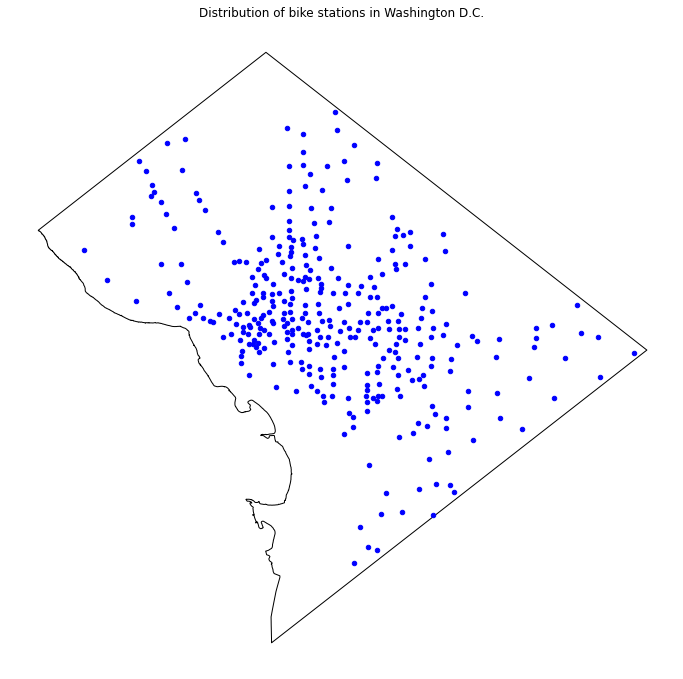

In [15]:
# visualize the distribution of both transit stops and bike stations
# for gis visualization
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

stops_info = gpd.GeoDataFrame(stops_info) # !!! Impportant (transit stops)

fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = DC_boundary.plot(ax=ax, color = 'white', edgecolor = 'black')
station_info.plot(ax=base1, markersize=20, color='blue', legend=True)  # (bike stations)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis("off")
plt.title('Distribution of bike stations in Washington D.C.')

100


,station_id,latitude,longitude,pop_den,housing_unit_den,LU_diversity,bike_density,geometry
292,31663.0,38.919285,-77.032802,0.013641,0.009056,2.281858,0.379401,POINT (-77.03280 38.91929)
16,31117.0,38.932580,-77.031001,0.011819,0.006866,1.729073,0.203655,POINT (-77.03100 38.93258)
219,31526.0,38.876740,-77.020671,0.004923,0.004261,1.371679,0.173125,POINT (-77.02067 38.87674)
247,31618.0,38.924943,-77.042212,0.014202,0.011644,1.978434,0.233945,POINT (-77.04221 38.92494)
295,31666.0,38.919423,-77.017050,0.004884,0.001399,1.942579,0.316389,POINT (-77.01705 38.91942)


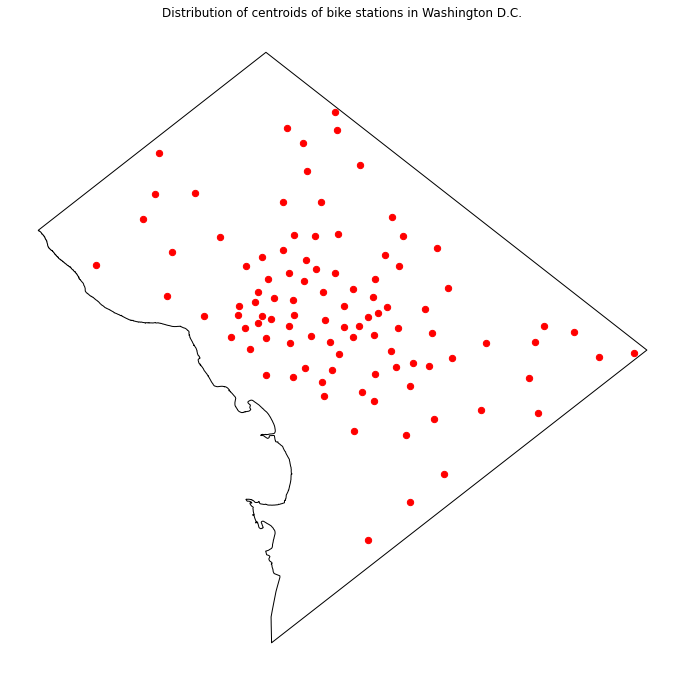

In [16]:
# cluster 352 bike stations into 100 centroids

station_id_geo = station_info[['station_id', 'latitude', 'longitude', 'geometry', 'pop_den', 'housing_unit_den', 'LU_diversity', 'bike_density']]

# cluster (352 bike stations) into (100 bike statios)
# K-means algorithm
K_cluster = 100 # cluster into 100 category
dist_sum = [np.inf]
dist_diff = np.inf
random.seed(10)
K_centroid_list = random.sample(range(0, len(station_id_geo)), K_cluster)
K_centroid_info = station_id_geo.iloc[K_centroid_list]
cluster_list = np.zeros(len(station_id_geo))
distance_list = np.zeros(len(station_id_geo))
while (dist_diff >= 1e-5):
    for i in range (len(station_id_geo)):
        distance_centroid = np.zeros(K_cluster) 
        for j in range(K_cluster):
            distance_centroid[j] = station_id_geo.geometry[i].distance(K_centroid_info.geometry.iloc[j])
        distance_list[i] = min(distance_centroid)
        cluster_list[i] = K_centroid_list[np.where(distance_centroid == distance_centroid.min())[0][0]]
    dist_sum.append(np.sum(distance_list))
    dist_diff = abs(dist_sum[-1] - dist_sum[-2])
    K_centroid_list = list(set(cluster_list))
    for i in range(K_cluster):
        index = K_centroid_list[i]
        K_centroid_info.latitude.iloc[i] = np.mean(station_id_geo.latitude.iloc[np.where(cluster_list == index)[0]])
        K_centroid_info.longitude.iloc[i] = np.mean(station_id_geo.longitude.iloc[np.where(cluster_list == index)[0]])
        K_centroid_info.pop_den.iloc[i] = np.mean(station_id_geo.pop_den.iloc[np.where(cluster_list == index)[0]])
        K_centroid_info.housing_unit_den.iloc[i] = np.mean(station_id_geo.housing_unit_den.iloc[np.where(cluster_list == index)[0]])
        K_centroid_info.LU_diversity.iloc[i] = np.mean(station_id_geo.LU_diversity.iloc[np.where(cluster_list == index)[0]])
        K_centroid_info.bike_density.iloc[i] = np.mean(station_id_geo.bike_density.iloc[np.where(cluster_list == index)[0]])
    K_centroid_info = K_centroid_info.drop(columns= {'geometry'}, axis = 1)
    K_centroid_info['geometry'] = K_centroid_info[['longitude','latitude']].values.tolist()
    K_centroid_info.geometry = K_centroid_info.geometry.apply(Point)

## K_centroid_list: index of centroid
## cluster_list: each station belong to which centroid
## K_centroid_info: each centroid info
## average latitude and longitude of neighboring bike stations as a ceontroid
print(len(K_centroid_info))

# draw a distirbution of 100 bike centroid
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = DC_boundary.plot(ax=ax, color = 'white', edgecolor = 'black') # color='#d3d3d3'
K_centroid_info.plot(column='Centroid', ax=base1, markersize=40, color='red', legend=True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution of centroids of bike stations in Washington D.C.')
plt.axis('off')
K_centroid_info.head()

Text(0.5, 1.0, 'Distribution of centroids and transit stops in Washington D.C.')

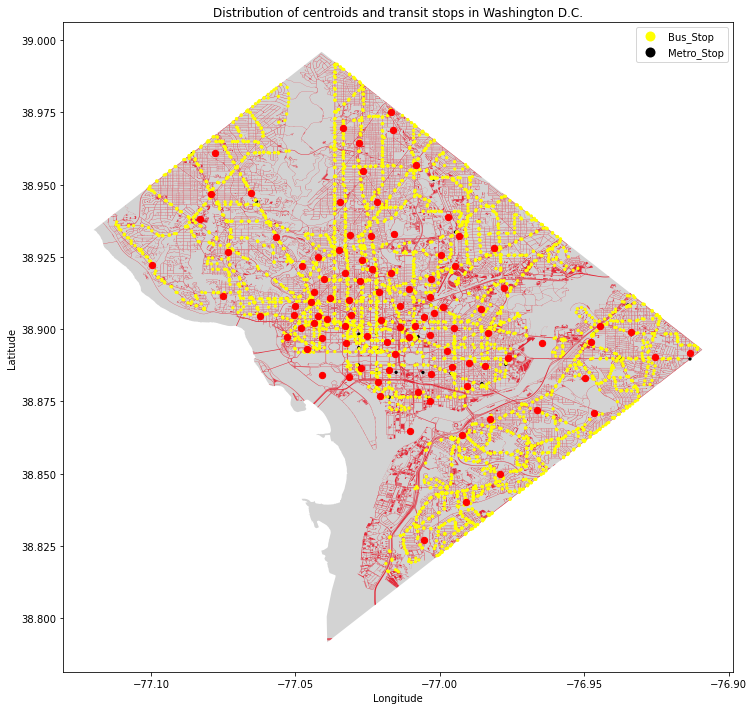

In [17]:
# visualize transit stop and bike centroids
# for gis visualization
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

stops_info = gpd.GeoDataFrame(stops_info) # !!! Impportant

fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = DC_boundary.plot(ax=ax, color='#d3d3d3')
base2 = DC_road_info.plot(ax=base1, color='#e32636')
stop_palette = {'Bus_Stop': 'black', 'Metro_Stop': 'yellow'}
cmap = matplotlib.colors.ListedColormap([stop_palette[b] for b in stops_info.route_type.unique()])
base3 = stops_info.plot(column='route_type', ax=base2, markersize=5,  legend=True, cmap = cmap) # Plot
K_centroid_info.plot(ax=base3, markersize=40, color = 'red', legend=True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution of centroids and transit stops in Washington D.C.')

Text(0.5, 1.0, 'Distribution of centroids and transit stops in Washington D.C.')

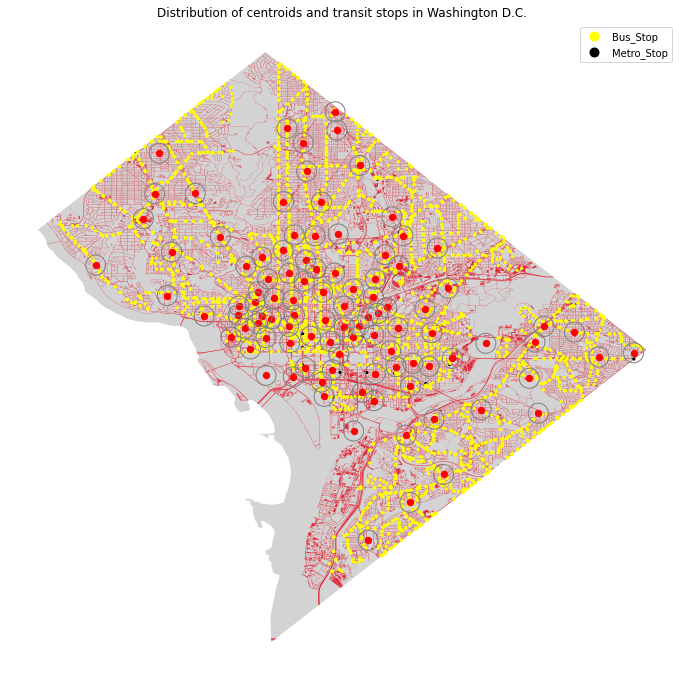

In [18]:
# visualize transit stop and bike centroids, as well as its buffer service area
# for gis visualization
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

stops_info = gpd.GeoDataFrame(stops_info) # !!! Impportant

fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = DC_boundary.plot(ax=ax, color='#d3d3d3')
base2 = DC_road_info.plot(ax=base1, color='#e32636')
stop_palette = {'Bus_Stop': 'black', 'Metro_Stop': 'yellow'}
cmap = matplotlib.colors.ListedColormap([stop_palette[b] for b in stops_info.route_type.unique()])
base3 = stops_info.plot(column='route_type', ax=base2, markersize=5,  legend=True, cmap = cmap) # Plot
K_centroid_info.plot(ax=base3, markersize=40, color = 'red', legend=True)
K_centroid_info.plot(ax=base3, markersize=400, marker='o', facecolors='none', edgecolors='grey')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('off')
plt.title('Distribution of centroids and transit stops in Washington D.C.')

116


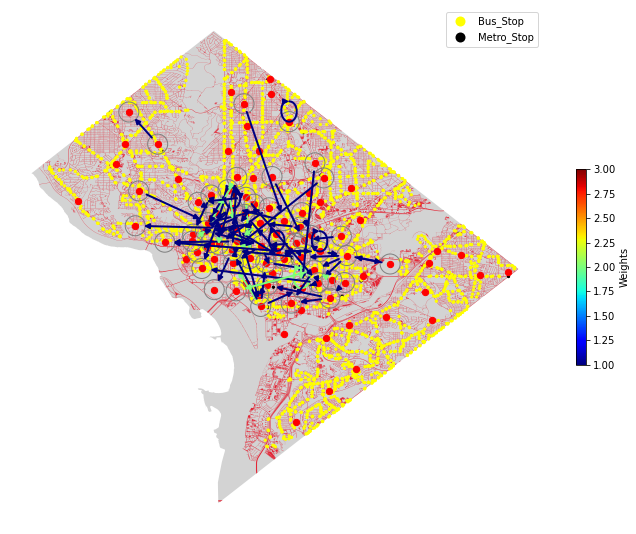

average degree: 0.015806451612903217
average pagerank: 0.009999999999999997
average betweenness: 0.0064833421470121624


In [19]:
# construct a graph structure based on OD flow bike trips data

# select one certain time period 8:00 am - 9:00 am, 03/01/20
# draw the graph: nodes, edges, and weights
start_date_030189 = datetime(2020, 3, 1, 8)
end_date_030189 = datetime(2020, 3, 1, 9)
sharing_bike_data_030189 = sharingbikedata.loc[(sharingbikedata['Start date'] >= start_date_030189) & (sharingbikedata['Start date'] <= end_date_030189)]
sharing_bike_data_030189 = sharing_bike_data_030189.drop(columns={'start_lat', 'start_lon', 'end_lat', 'end_lon'}, axis=1)
print(len(sharing_bike_data_030189))

## calculate weights of different controids in a graph
## replace original latitude and longitude with new centroid one
# weight matrix: weights_030189
weights_030189 = np.zeros((len(K_centroid_info), len(K_centroid_info)))
for i in range (len(sharing_bike_data_030189)):
    o_index = station_info[station_info['station_id'] == sharing_bike_data_030189['Start station number'].iloc[i]].index[0]
    o_index = np.where(K_centroid_list == cluster_list[o_index])[0][0]
    sharing_bike_data_030189['start_geo'].iloc[i] = K_centroid_info.geometry.iloc[o_index]
    d_index = station_info[station_info['station_id'] == sharing_bike_data_030189['End station number'].iloc[i]].index[0]
    d_index = np.where(K_centroid_list == cluster_list[d_index])[0][0]
    sharing_bike_data_030189['end_geo'].iloc[i] = K_centroid_info.geometry.iloc[d_index]
    weights_030189[o_index, d_index] = weights_030189[o_index, d_index] + 1


# draw a base map of bike ceontriods and DC boudnary
stops_info = gpd.GeoDataFrame(stops_info) # !!! Impportant
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = DC_boundary.plot(ax=ax, color='#d3d3d3')
base2 = DC_road_info.plot(ax=base1, color='#e32636')
stop_palette = {'Bus_Stop': 'black', 'Metro_Stop': 'yellow'}
cmap = matplotlib.colors.ListedColormap([stop_palette[b] for b in stops_info.route_type.unique()])
base3 = stops_info.plot(column='route_type', ax=base2, markersize=5,  legend=True, cmap = cmap) # Plot
K_centroid_info.plot(ax=base3, markersize=40, color = 'red', legend=True)
plt.axis("off")


# construct a directed graph of bike OD flow trips 
G = nx.DiGraph()
initialpos = {0:K_centroid_info.geometry.iloc[0]}
for i in range (1, len(K_centroid_info)):
    initialpos.update({i:K_centroid_info.geometry.iloc[i]})

initialpos = {k: (v.x, v.y) for k, v in initialpos.items()}
nodes = nx.draw_networkx_nodes(G, initialpos, node_size = 100)
node_index_nonzeros = []
G_weighted_edge = []
for i in range(len(K_centroid_info)):
    for j in range(len(K_centroid_info)):
        if weights_030189[i][j] != 0:
            G_weighted_edge.append((i, j, int(weights_030189[i][j])))
            node_index_nonzeros.append(i)
            node_index_nonzeros.append(j)
G.add_weighted_edges_from(G_weighted_edge)
node_index_nonzeros = list(set(node_index_nonzeros))
K_centroid_info.iloc[node_index_nonzeros].plot(ax=base3, markersize=400, marker='o', facecolors='none', edgecolors='grey')
edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
edges = nx.draw_networkx_edges(G, initialpos, edge_color=edge_colors, width=2, edge_cmap=plt.cm.jet) # Blues
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet)
sm.set_array(edge_colors)
plt.colorbar(sm, label = "Weights", orientation = "vertical", shrink = 0.3)
plt.show()


## output statistical metrics

# degree
graph_in_degree = nx.in_degree_centrality(G)
print('average degree:', sum(graph_in_degree.values())/K_cluster)
    
# pagerank
graph_pagerank = nx.pagerank(G)
print('average pagerank:', sum(graph_pagerank.values())/K_cluster)

# betweenness
graph_betweenness = nx.betweenness_centrality(G, normalized=True, endpoints=False)
print('average betweenness:', sum(graph_betweenness.values())/K_cluster)

In [20]:
# construct basic information of 100 bike centroids
K_centroid_att_sarray = K_centroid_info.copy()
K_centroid_att_sarray = K_centroid_att_sarray.drop(columns = {'geometry'}, axis = 1).reset_index(drop=True)
#K_centroid_att_sarray.to_csv('Data/K_centroid_att_sarray.csv', index = False)
K_centroid_att_sarray.head()

,station_id,latitude,longitude,pop_den,housing_unit_den,LU_diversity,bike_density
0,31663.0,38.919285,-77.032802,0.013641,0.009056,2.281858,0.379401
1,31117.0,38.932580,-77.031001,0.011819,0.006866,1.729073,0.203655
2,31526.0,38.876740,-77.020671,0.004923,0.004261,1.371679,0.173125
3,31618.0,38.924943,-77.042212,0.014202,0.011644,1.978434,0.233945
4,31666.0,38.919423,-77.017050,0.004884,0.001399,1.942579,0.316389


In [21]:
# construct a graph structure based on OD flow bike trips data
bike_data_attribute_array = []
for mm in range(1, 32):
    for nn in range (24):
        start_date = datetime(2020, 3, mm, nn)
        end_date = start_date + timedelta(hours = 1)
        sharing_bike_data = sharingbikedata.loc[(sharingbikedata['Start date'] >= start_date) & (sharingbikedata['Start date'] <= end_date)]
        sharing_bike_data = sharing_bike_data.drop(columns={'start_lat', 'start_lon', 'end_lat', 'end_lon'}, axis=1)
        print(((mm-1)*24+nn, len(sharing_bike_data)))

        ## calculate weights of different controids in a graph
        ## replace original latitude and longitude with new centroid one
        weights = np.zeros((len(K_centroid_info), len(K_centroid_info)))
        for i in range (len(sharing_bike_data)):
            o_index = station_info[station_info['station_id'] == sharing_bike_data['Start station number'].iloc[i]].index[0]
            o_index = np.where(K_centroid_list == cluster_list[o_index])[0][0]
            sharing_bike_data['start_geo'].iloc[i] = K_centroid_info.geometry.iloc[o_index]
            d_index = station_info[station_info['station_id'] == sharing_bike_data['End station number'].iloc[i]].index[0]
            d_index = np.where(K_centroid_list == cluster_list[d_index])[0][0]
            sharing_bike_data['end_geo'].iloc[i] = K_centroid_info.geometry.iloc[d_index]
            weights[o_index, d_index] = weights[o_index, d_index] + 1

        # construct a directed graph of bike OD flow trips 
        G = nx.DiGraph()
        node_index_nonzeros = []
        G_weighted_edge = []
        for i in range(len(K_centroid_info)):
            for j in range(len(K_centroid_info)):
                if weights[i][j] != 0:
                    G_weighted_edge.append((i, j, int(weights[i][j])))
                    node_index_nonzeros.append(i)
                    node_index_nonzeros.append(j)
        G.add_weighted_edges_from(G_weighted_edge)
        node_index_nonzeros = list(set(node_index_nonzeros))

        # calculate time-depenent dynamic number of transit stops in service around bike sations
        # extract all transit stop information (stop geometry and unique stopid)
        stop_geo = gpd.GeoDataFrame({'geometry': stops_info.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')
        stop_geo['stop_id'] = stops_info.stop_id
        stop_geo['route_type'] = stops_info.route_type
        # extract those (not all) bike centroid information with OD flow trips
        station_geo = gpd.GeoDataFrame({'geometry': K_centroid_info.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')
        # compute distance between these bike controid and all transit stop, and store those stop id near bike centriods into a list
        stop_id_cover = [] # A list of all stop id for each bike centroid
        stop_id_cover_metro = [] # A list whose element is a list of metro stop id for each bike centroid
        stop_id_cover_bus = [] # A list whose element is a list of bus stop id for each bike centroid
        stop_geo_metro = stop_geo.loc[stop_geo['route_type'] == 'Metro_Stop']
        stop_geo_bus = stop_geo.loc[stop_geo['route_type'] == 'Bus_Stop']
        for i in range (len(station_geo)):
            stop_id_cover_metro.append([])
            stop_id_cover_bus.append([])
            if i in node_index_nonzeros:
                for j in range (len(stop_geo_metro)):
                    if station_geo.geometry.iloc[i].distance(stop_geo_metro.geometry.iloc[j])/1000 < 0.2: # set 200m as a radius of buffer area of each controid
                        stop_id_cover_metro[i].append(stop_geo_metro['stop_id'].iloc[j])
                        stop_id_cover.append(stop_geo_metro['stop_id'].iloc[j])
                for k in range (len(stop_geo_bus)):
                    if station_geo.geometry.iloc[i].distance(stop_geo_bus.geometry.iloc[k])/1000 < 0.2: # set 200m as a radius of buffer area of each controid
                        stop_id_cover_bus[i].append(stop_geo_bus['stop_id'].iloc[k])
                        stop_id_cover.append(stop_geo_bus['stop_id'].iloc[k])

        stop_id_cover = list(set(stop_id_cover))

        # count how many transit schedules/routes in service that cross these stop id (one stop id may count multiple time)
        # extract transit schedule within specific time windows
        transit_stops = transit_stops_march[['stop_id', 'geometry']].loc[(transit_stops_march['arrival_time'] >= start_date) & (transit_stops_march['arrival_time'] <= end_date)]
        transit_stops = transit_stops.loc[transit_stops['stop_id'].isin(stop_id_cover)] 

        # compute the static and dynamic number of transit stops around each bike centroid
        metro_stop_dnum = []
        bus_stop_dnum = []
        metro_stop_snum = []
        bus_stop_snum = []
        for i in range (len(station_geo)):
            metro_stop_dnum.append(len(transit_stops.loc[transit_stops['stop_id'].isin(stop_id_cover_metro[i])]))
            bus_stop_dnum.append(len(transit_stops.loc[transit_stops['stop_id'].isin(stop_id_cover_bus[i])]))
            metro_stop_snum.append(len(stop_id_cover_metro[i]))
            bus_stop_snum.append(len(stop_id_cover_bus[i]))
        metro_stop_dnum = np.array(metro_stop_dnum)
        bus_stop_dnum = np.array(bus_stop_dnum)
        metro_stop_snum = np.array(metro_stop_snum)
        bus_stop_snum = np.array(bus_stop_snum)

        ### add a set of attributes

        ## add public transit information
        K_centroid_attribute = K_centroid_info[['pop_den', 'housing_unit_den', 'LU_diversity', 'bike_density']].reset_index(drop=True)
        K_centroid_attribute['metro_stop_dnum'] = metro_stop_dnum
        K_centroid_attribute['bus_stop_dnum'] = bus_stop_dnum
        K_centroid_attribute['metro_stop_snum'] = metro_stop_snum
        K_centroid_attribute['bus_stop_snum'] = bus_stop_snum

        ## add graph attribute information
        # degree
        graph_out_degree = nx.out_degree_centrality(G)
        degree = np.zeros(len(K_centroid_info))
        degree[node_index_nonzeros] = list(graph_out_degree.values())
        K_centroid_attribute['degree'] = degree
        # strength
        graph_out_strength = []
        for i in node_index_nonzeros:
            graph_out_strength.append(np.sum([d['weight'] for u, v, d in G.out_edges(i, data=True)]))
        strength = np.zeros(len(K_centroid_info))
        strength[node_index_nonzeros] = np.array(graph_out_strength)
        K_centroid_attribute['strength'] = strength
        # pagerank
        graph_pagerank = nx.pagerank(G)
        pagerank = np.zeros(len(K_centroid_info))
        pagerank[node_index_nonzeros] = list(graph_pagerank.values())
        K_centroid_attribute['pagerank'] = pagerank
        # betweenness
        graph_betweenness = nx.betweenness_centrality(G, normalized=True, endpoints=False)
        betweenness = np.zeros(len(K_centroid_info))
        betweenness[node_index_nonzeros] = list(graph_betweenness.values())
        K_centroid_attribute['betweenness'] = betweenness
        
        # bike centroid
        K_centroid_attribute['ridership'] = strength

        # store data set into the corresponding array
        bike_data_attribute_array.append(K_centroid_attribute.values)

(0, 43)
(1, 30)
(2, 26)
(3, 10)
(4, 3)
(5, 8)
(6, 20)
(7, 44)
(8, 116)
(9, 175)
(10, 267)
(11, 350)
(12, 409)
(13, 446)
(14, 501)
(15, 460)
(16, 483)
(17, 414)
(18, 274)
(19, 181)
(20, 120)
(21, 99)
(22, 61)
(23, 33)
(24, 12)
(25, 4)
(26, 0)
(27, 1)
(28, 16)
(29, 66)
(30, 211)
(31, 538)
(32, 912)
(33, 411)
(34, 225)
(35, 236)
(36, 291)
(37, 307)
(38, 291)
(39, 397)
(40, 511)
(41, 754)
(42, 669)
(43, 329)
(44, 172)
(45, 108)
(46, 31)
(47, 39)
(48, 22)
(49, 5)
(50, 2)
(51, 2)
(52, 16)
(53, 78)
(54, 245)
(55, 594)
(56, 1055)
(57, 436)
(58, 203)
(59, 138)
(60, 123)
(61, 161)
(62, 208)
(63, 365)
(64, 484)
(65, 975)
(66, 672)
(67, 243)
(68, 231)
(69, 110)
(70, 101)
(71, 48)
(72, 22)
(73, 4)
(74, 1)
(75, 5)
(76, 8)
(77, 87)
(78, 262)
(79, 616)
(80, 1011)
(81, 456)
(82, 229)
(83, 257)
(84, 327)
(85, 299)
(86, 319)
(87, 407)
(88, 588)
(89, 947)
(90, 736)
(91, 431)
(92, 329)
(93, 219)
(94, 165)
(95, 50)
(96, 26)
(97, 10)
(98, 4)
(99, 1)
(100, 8)
(101, 71)
(102, 271)
(103, 564)
(104, 997)
(105, 4

In [22]:
# select the first hour on the first day as an example to show all related variables
column_name = ['pop_den', 'housing_unit_den', 'LU_diversity', 'bike_density', 'metro_stop_dnum', 'bus_stop_dnum', 
               'metro_stop_snum', 'bus_stop_snum', 'degree', 'strength', 'pagerank', 'betweenness', 'ridership']
bike_data_attribute_array0 = pd.DataFrame(bike_data_attribute_array[0])
bike_data_attribute_array0.columns = column_name
print(len(bike_data_attribute_array0))
bike_data_attribute_array0.head()

100


,pop_den,housing_unit_den,LU_diversity,bike_density,metro_stop_dnum,bus_stop_dnum,metro_stop_snum,bus_stop_snum,degree,strength,pagerank,betweenness,ridership
0,0.013641,0.009056,2.281858,0.379401,0.0,0.0,0.0,2.0,0.078947,3.0,0.023562,0.000000,3.0
1,0.011819,0.006866,1.729073,0.203655,0.0,0.0,0.0,2.0,0.026316,1.0,0.064913,0.004979,1.0
2,0.004923,0.004261,1.371679,0.173125,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
3,0.014202,0.011644,1.978434,0.233945,0.0,0.0,0.0,1.0,0.105263,1.0,0.020138,0.007824,1.0
4,0.004884,0.001399,1.942579,0.316389,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0


In [23]:
## ========================================= Variable Selection Based on SpVAR-LASSO Model ==================================##

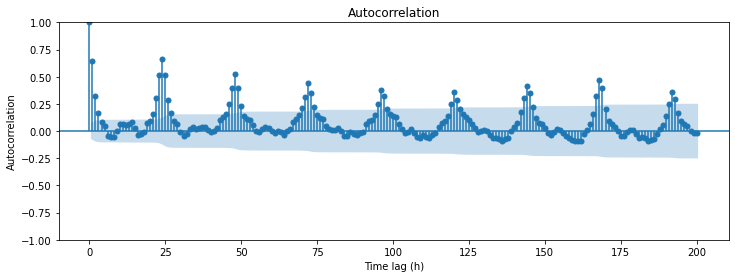

In [24]:
# ACF
import statsmodels.api as sm

bike_data_array = bike_data_attribute_array.copy()

fig, ax = plt.subplots(figsize=(12, 4))
sm.graphics.tsa.plot_acf(np.array(bike_data_array)[:,0,-1], lags = 200, ax=ax)
plt.xlabel('Time lag (h)')
plt.ylabel('Autocorrelation')
plt.show()

In [25]:
# geographical adjacency matrix based on physical proximity (100*100)
centroid_geometry = gpd.GeoDataFrame({'geometry': K_centroid_info['geometry']}, crs='EPSG:4326').to_crs('EPSG:5234')
gw_centroid = np.zeros((len(K_centroid_info), len(K_centroid_info)))
for i in range (len(K_centroid_info)):
    for j in range (i+1, len(K_centroid_info)):
        gw_centroid[i,j] = 1000/centroid_geometry.iloc[i][0].distance(centroid_geometry.iloc[j][0]) #1/(dist/1000)
gw_centroid = gw_centroid + gw_centroid.T # 100*100
gw_centroid = gw_centroid

In [35]:
## SpVAR-LASSO Model
import libpysal as ps
from spreg import GM_Lag
from sklearn.linear_model import LassoCV
import warnings
warnings.filterwarnings('ignore')

# define two kinds of spatial relationship, along with weight matrix
neighbors = {}
gw_weights = {}
for i in range(len(K_centroid_info)):
    aa = list(np.arange(len(K_centroid_info)))
    aa.remove(i)
    neighbors[i] = aa
    bb = list(gw_centroid[i, :])
    bb.remove(0)
    gw_weights[i] = list(np.array(bb) + 1e-4)

# Create a PySAL W object with the neighbors and weights
gw_w = ps.weights.W(neighbors, weights = gw_weights)
gw_w.transform = 'r'

bike_data_array = bike_data_attribute_array.copy()
bike_data_array = np.array(bike_data_array)

for i in range (len(bike_data_array)):
    bike_data_array[i,:,-1] = bike_data_array[i,:,-1] + np.random.rand(len(K_centroid_info))/1e3
    
time_list = list(np.arange(29))  # before and after 5 hour at 1,2,3,4,5,6,7days
for i in [43, 67, 91, 115, 139, 163]:
    for j in range(10):
        time_list.append(i+j)
time_list = np.array(time_list[0:-5])

order_step = 168
mse_dataset = []
coef_dataset = []
pred_dataset = []
for i in range (order_step, len(bike_data_array)): # len(bike_data_array)
    station_spatial_reg = pd.DataFrame({'demand_pred': bike_data_array[i,:,-1],
                                     #'degree': bike_data_array[i,:,-5],
                                     #'pagerank': bike_data_array[i,:,-3],
                                     #'betweenness': bike_data_array[i,:,-2],
                                     'pop_density': bike_data_array[i,:,0],
                                     'housing_unit_den': bike_data_array[i,:,1],
                                     'LU_diversity': bike_data_array[i,:,2],
                                     'bike_density': bike_data_array[i,:,3],
                                     'metro_stop_dnum': bike_data_array[i,:,4] + np.random.rand(len(K_centroid_info))/1e4,
                                     'bus_stop_dnum': bike_data_array[i,:,5] + np.random.rand(len(K_centroid_info))/1e4,
                                     'metro_stop_snum': bike_data_array[i,:,6] + np.random.rand(len(K_centroid_info))/1e4,
                                     'bus_stop_snum': bike_data_array[i,:,7] + np.random.rand(len(K_centroid_info))/1e4})
    station_spatial_reg = station_spatial_reg.values
    for j in time_list: # time_list
        station_spatial_reg = np.append(station_spatial_reg, bike_data_array[i-j-1,:,-1].reshape(-1, 1), axis=1)

    # Load data
    X = station_spatial_reg[:, 1:]
    y = station_spatial_reg[:, 0]

    print(i)

    # Create spatial vector autoregressive Lasso model
    model = GM_Lag(y, X, w=gw_w)

    # Fit model with Lasso regularization using cross-validation
    alphas = np.logspace(-4, 2, num=100)
    lasso_cv = LassoCV(alphas=alphas, cv=10)
    lasso_cv.fit(model.x, model.y)

    # Evaluate model performance
    pred = lasso_cv.predict(model.x)
    pred_dataset.append(pred)
    
    mse = np.mean((pred - model.y.reshape(1,-1)[0]) ** 2)
    mse_dataset.append(mse)
    coef_dataset.append(lasso_cv.coef_)
    

168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417


[0.0001     0.00011498 0.00013219 0.00015199 0.00017475 0.00020092
 0.00023101 0.00026561 0.00030539 0.00035112 0.0004037  0.00046416
 0.00053367 0.00061359 0.00070548 0.00081113 0.0009326  0.00107227
 0.00123285 0.00141747 0.00162975 0.00187382 0.00215443 0.00247708
 0.00284804]


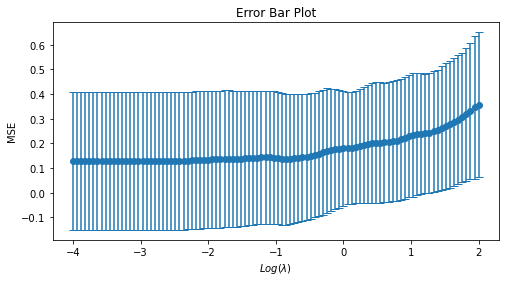

In [36]:
## CV plots
alphas = np.logspace(-4, 2, num=100)
CV_alphas_output = lasso_cv.mse_path_
CV_alphas_mean = np.mean(CV_alphas_output, axis = 1)
CV_alphas_std = np.std(CV_alphas_output, axis = 1)
print(alphas[np.where(CV_alphas_mean == min(CV_alphas_mean))[0]])

# Plot the data with error bars
plt.figure (figsize = (8,4))
plt.errorbar(np.log10(alphas), CV_alphas_mean, yerr = CV_alphas_std, fmt='o', capsize=4)

lamda = r'$ Log(\lambda$)'

# Add labels and a title
plt.xlabel(f'{lamda}')
plt.ylabel('MSE')
plt.title('Error Bar Plot')

# Show the plot
plt.show()

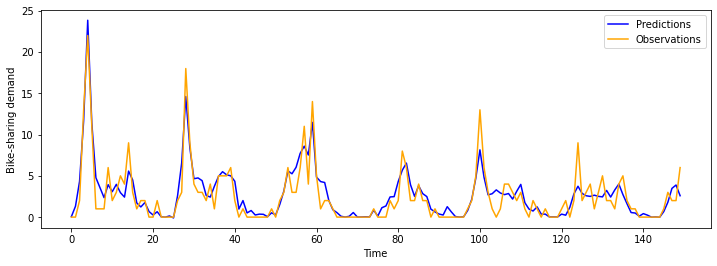

In [37]:
pred_dataset = np.array(pred_dataset)
plt.figure(figsize = (12, 4))
l1 = plt.plot(pred_dataset[100:250,72], 'blue')
l2 = plt.plot(bike_data_array[100+168:250+168,72, -1], 'orange')
plt.xlabel('Time')
plt.ylabel('Bike-sharing demand')
plt.legend(['Predictions', 'Observations'])
plt.show()

Text(0, 0.5, 'Probability density')

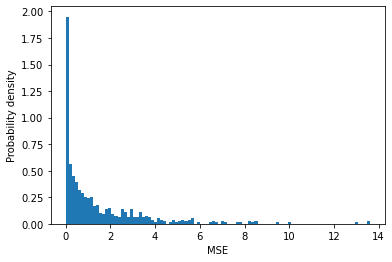

In [38]:
mse_dataset = np.array(mse_dataset)
l1 = plt.hist(mse_dataset, bins = 100, density = True)
plt.xlabel('MSE')
plt.ylabel('Probability density')

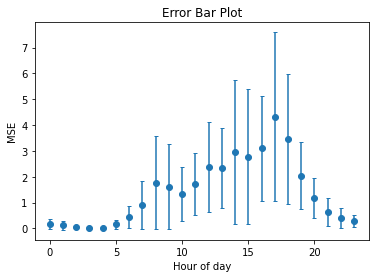

In [39]:
mse_dataset_plot = mse_dataset.reshape((24,24))
mse_dataset_plot_mean = np.mean(mse_dataset_plot, axis = 0)
mse_dataset_plot_std = np.std(mse_dataset_plot, axis = 0)
plt.errorbar(np.arange(24), mse_dataset_plot_mean, yerr = mse_dataset_plot_std, fmt='o', capsize=2)

# Add labels and a title
plt.xlabel('Hour of day')
plt.ylabel('MSE')
plt.title('Error Bar Plot')

# Show the plot
plt.show()

[ 5  6  8 32 52 62 72 82 92]
[374 531  95 109  91  94  90  96 114]


Text(0.5, 1.0, 'Percentage of non-zero coefficients')

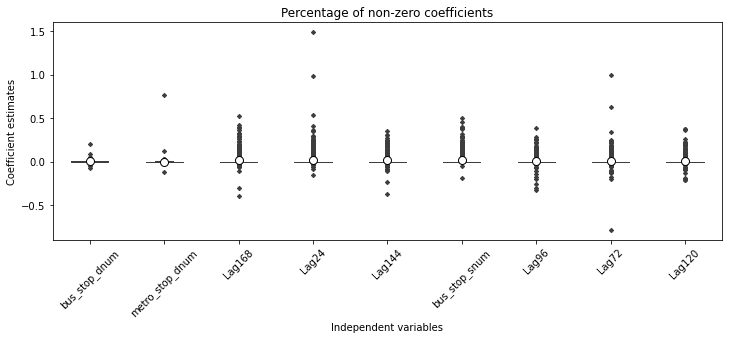

In [41]:
coef_dataset = np.array(coef_dataset)

non_zero_count = []
for i in range (coef_dataset.shape[1]):
    non_zero_count.append(np.sum(coef_dataset[:, i] != 0))
non_zero_count = np.array(non_zero_count)
index_list_nonzero = np.where(non_zero_count >= 90)
print(index_list_nonzero[0])
print(non_zero_count[index_list_nonzero[0]])

# 'metro_stop_dnum', 'bus_stop_dnum', 'bus_stop_snum', lag24, lag72, lag96, lag120, lag144, lag168 
# order: 'bus_stop_dnum', 'metro_stop_dnum', lag168, lag24, 'bus_stop_snum', lag144, lag96, lag72, lag120,

data_coef_est = pd.DataFrame({'bus_stop_dnum': coef_dataset[:, index_list_nonzero[0][1]],
                              'metro_stop_dnum': coef_dataset[:, index_list_nonzero[0][0]],
                              'Lag168': coef_dataset[:, index_list_nonzero[0][8]],
                              'Lag24': coef_dataset[:, index_list_nonzero[0][3]],
                              'Lag144': coef_dataset[:, index_list_nonzero[0][7]],
                              'bus_stop_snum': coef_dataset[:, index_list_nonzero[0][2]],
                              'Lag96': coef_dataset[:, index_list_nonzero[0][5]],
                              'Lag72': coef_dataset[:, index_list_nonzero[0][4]],
                              'Lag120': coef_dataset[:, index_list_nonzero[0][6]]})

# draw boxplot
plt.figure(figsize = (12, 4))
sns.boxplot(data = data_coef_est,
            linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            flierprops = dict(marker='D', markersize=3),
            #showfliers = False,
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
#plt.ylim([-0.2, 0.6])
plt.xlabel('Independent variables')
plt.xticks(rotation = 45)
plt.ylabel('Coefficient estimates')
plt.title('Percentage of non-zero coefficients')  # 576 regression equations

In [ ]:
## ================================================= data preparation ====================================================##

In [42]:
## data preparation: array (time * bike_centroid : 744-order * 100)

order = 168

# hourly demand: dependent variables
lag_0 = np.array(bike_data_attribute_array)[order:,:,-1]

# temporal features: lag24, lag72, lag96, lag120, lag144, lag168: independent variables
lag_24 = np.array(bike_data_attribute_array)[order-24:-24,:,-1]
lag_72 = np.array(bike_data_attribute_array)[order-72:-72,:,-1]
lag_96 = np.array(bike_data_attribute_array)[order-96:-96,:,-1]
lag_120 = np.array(bike_data_attribute_array)[order-120:-120,:,-1]
lag_144 = np.array(bike_data_attribute_array)[order-144:-144,:,-1]
lag_168 = np.array(bike_data_attribute_array)[order-168:-168,:,-1]

# public transit information: metro_stop_dnum, metro_stop_snum, bus_stop_dnum, bus_stop_snum: independent variables
metro_dnum_0 = np.array(bike_data_attribute_array)[order:,:,4]
bus_dnum_0 = np.array(bike_data_attribute_array)[order:,:,5]
bus_snum_0 = np.array(bike_data_attribute_array)[order:,:,7]

# time-lagged (24,72,96,120,144,168h lagged) graph: degree, pagerank, betweenness: independent variables
degree_24 = np.array(bike_data_attribute_array)[order-24:-24,:,8]
pagerank_24 = np.array(bike_data_attribute_array)[order-24:-24,:,10]
betweenness_24 = np.array(bike_data_attribute_array)[order-24:-24,:,11]

degree_72 = np.array(bike_data_attribute_array)[order-72:-72,:,8]
pagerank_72 = np.array(bike_data_attribute_array)[order-72:-72,:,10]
betweenness_72 = np.array(bike_data_attribute_array)[order-72:-72,:,11]

degree_96 = np.array(bike_data_attribute_array)[order-96:-96,:,8]
pagerank_96 = np.array(bike_data_attribute_array)[order-96:-96,:,10]
betweenness_96 = np.array(bike_data_attribute_array)[order-96:-96,:,11]

degree_120 = np.array(bike_data_attribute_array)[order-120:-120,:,8]
pagerank_120 = np.array(bike_data_attribute_array)[order-120:-120,:,10]
betweenness_120 = np.array(bike_data_attribute_array)[order-120:-120,:,11]

degree_144 = np.array(bike_data_attribute_array)[order-144:-144,:,8]
pagerank_144 = np.array(bike_data_attribute_array)[order-144:-144,:,10]
betweenness_144 = np.array(bike_data_attribute_array)[order-144:-144,:,11]

degree_168 = np.array(bike_data_attribute_array)[order-168:-168,:,8]
pagerank_168 = np.array(bike_data_attribute_array)[order-168:-168,:,10]
betweenness_168 = np.array(bike_data_attribute_array)[order-168:-168,:,11]

In [97]:
# descriptive statistics: hourly ridership, graph, public transit
K_centroid_info[['pop_den', 'housing_unit_den', 'LU_diversity', 'bike_density']].describe()

,pop_den,housing_unit_den,LU_diversity,bike_density
count,100.000000,100.000000,100.000000,100.000000
mean,0.005227,0.003383,1.941334,0.276106
std,0.003681,0.002918,0.382158,0.202498
min,0.000002,0.000000,0.610679,0.008792
25%,0.002606,0.001442,1.728750,0.126218
50%,0.003969,0.002430,1.957349,0.242730
75%,0.006921,0.004178,2.170007,0.393001
max,0.015973,0.013069,2.632981,1.000000


In [98]:
# descriptive statistics: built environment factors
tripfactor_data_stat = pd.DataFrame({'hour_ridership': np.array(bike_data_attribute_array)[:,:,-1].flatten(),
                                     'degree': np.array(bike_data_attribute_array)[:,:,8].flatten(),
                                     'pagerank': np.array(bike_data_attribute_array)[:,:,10].flatten(),
                                     'betweenness': np.array(bike_data_attribute_array)[:,:,11].flatten(),
                                     'metro_dnum': np.array(bike_data_attribute_array)[:,:,4].flatten(),
                                     'bus_dnum': np.array(bike_data_attribute_array)[:,:,5].flatten(),
                                     'metro_snum': np.array(bike_data_attribute_array)[:,:,6].flatten(),
                                     'bus_snum': np.array(bike_data_attribute_array)[:,:,7].flatten()})
tripfactor_data_stat.describe()

,hour_ridership,degree,pagerank,betweenness,metro_dnum,bus_dnum,metro_snum,bus_snum
count,74400.000000,74400.000000,74400.000000,74400.000000,74400.000000,74400.000000,74400.000000,74400.000000
mean,1.797097,0.020799,0.009839,0.008102,9.228616,55.784315,0.068199,1.911694
std,3.979097,0.040614,0.025001,0.021485,38.762549,104.859229,0.252089,2.748796
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.002350,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.028571,0.011532,0.002163,0.000000,76.000000,0.000000,4.000000
max,72.000000,2.000000,1.000000,0.500000,383.000000,1119.000000,1.000000,15.000000


Text(0, 0.5, 'Hourly bike ridership')

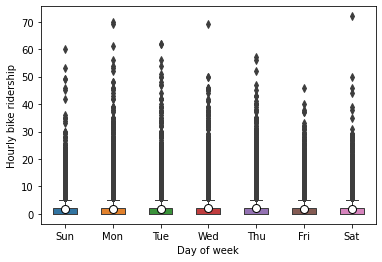

In [104]:
# temporal distribution
bike_demand_vis = np.array(bike_data_attribute_array)[:,:,-1]
week_list = [['Sun'] * 2400, ['Mon'] * 2400, ['Tue'] * 2400, ['Wed'] * 2400, ['Thu'] * 2400, ['Fri'] * 2400, ['Sat'] * 2400]
week_list = np.array(list(np.array(week_list).flatten()) * 5)[0:bike_demand_vis.flatten().shape[0]]
hour_list = np.array(list(np.array([[i] * 100 for i in list(np.arange(24))]).flatten()) * 31)

bike_demand_plot = pd.DataFrame({'bike_demand': bike_demand_vis.flatten(),
                                'week': week_list,
                                'hour': hour_list})
# weekly variation

# draw boxplot
sns.boxplot(x = 'week', y = 'bike_demand', data = bike_demand_plot,
            linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            showfliers = True,
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
plt.xlabel('Day of week')
plt.ylabel('Hourly bike ridership')

Text(0, 0.5, 'Hourly bike ridership')

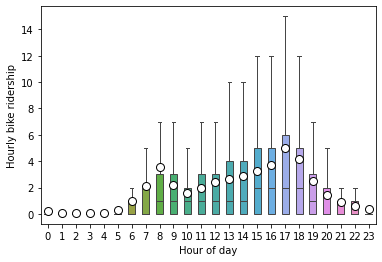

In [103]:
# hourly variation

# draw boxplot
sns.boxplot(x = 'hour', y = 'bike_demand', data = bike_demand_plot,
            linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            showfliers = False,
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
plt.xlabel('Hour of day')
plt.ylabel('Hourly bike ridership')

(-77.13032748188984, -76.89861769279194, 38.78142816699374, 39.00618422077411)

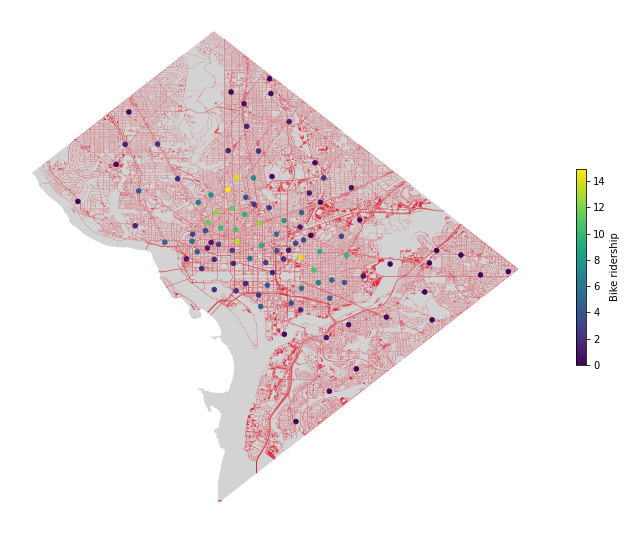

In [105]:
# spatial distribution

# morning rush hour (8 am)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

morning_rush = np.array([8 + i * 24 for i in range(31)])
evening_rush = np.array([17 + i * 24 for i in range(31)])
mor_bike_demand_vis = np.mean(bike_demand_vis[morning_rush, :], axis = 0)
eve_bike_demand_vis = np.mean(bike_demand_vis[evening_rush, :], axis = 0)

K_centroid_info_plot = K_centroid_info.copy()
K_centroid_info_plot['Mor_demand'] = mor_bike_demand_vis
K_centroid_info_plot['Eve_demand'] = eve_bike_demand_vis

fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = DC_boundary.plot(ax=ax, color='#d3d3d3')
base2 = DC_road_info.plot(ax=base1, color='#e32636')
base3 = K_centroid_info_plot.plot(column='Mor_demand', ax=base2, markersize=20, 
                                  legend_kwds={'label': "Bike ridership", 'orientation': "vertical", 'shrink': 0.3},
                                  legend=True)
plt.axis('off')

(-77.13032748188984, -76.89861769279194, 38.78142816699374, 39.00618422077411)

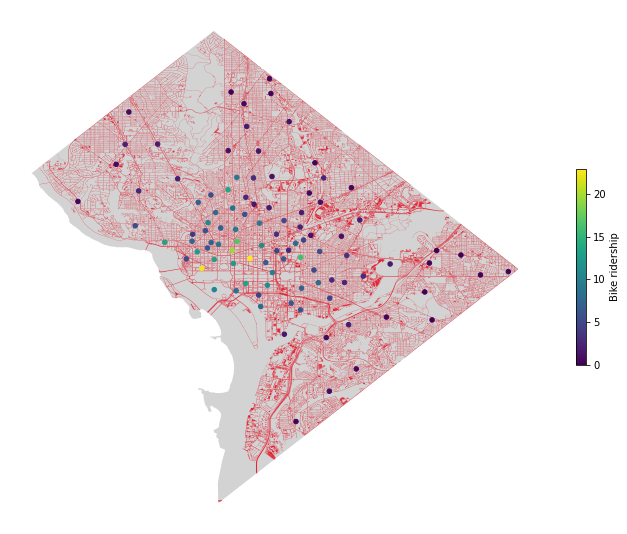

In [106]:
# spatial distribution

# evening rush hour
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = DC_boundary.plot(ax=ax, color='#d3d3d3')
base2 = DC_road_info.plot(ax=base1, color='#e32636')
base3 = K_centroid_info_plot.plot(column='Eve_demand', ax=base2, markersize=20, 
                                  legend_kwds={'label': "Bike ridership", 'orientation': "vertical", 'shrink': 0.3},
                                  legend=True)
plt.axis('off')

In [47]:
# meteorology: hourly visibility, temperature, dew point temp, humidity, wind speed, direction, and precipitation: independent variables (all stations share the same values)
meteorology = pd.read_csv('Data/weather_data_march.csv')
meteorology['Date'] = pd.to_datetime(meteorology['Date'])
meteorology['Day'] = meteorology['Date'].dt.day
meteorology['Hour'] = meteorology['Date'].dt.hour

# convert it into hourly stastics baased on date
meteorology_1 = meteorology.copy()
meteorology_1 = meteorology_1.drop(columns = {'Date'}, axis = 1)
meteorology_hourly = meteorology_1.groupby(['Day', 'Hour']).mean()
meteorology_0 = meteorology_hourly.values
print(meteorology_0.shape)
meteorology_0  # hourly values * 7 weather variables = 744 * 7

(744, 7)


array([[ 1.00000000e+01,  6.00000000e-01, -1.11000000e+01, ...,
         9.00000000e+00,  3.00000000e+02,  0.00000000e+00],
       [ 9.97000000e+00,  3.00000000e-01, -1.08500000e+01, ...,
         8.50000000e+00,  3.05000000e+02,  0.00000000e+00],
       [ 1.00000000e+01, -6.00000000e-01, -1.06000000e+01, ...,
         5.00000000e+00,  3.40000000e+02,  0.00000000e+00],
       ...,
       [ 1.00000000e+01,  7.20000000e+00,  5.60000000e+00, ...,
         1.30000000e+01,  6.00000000e+01,  3.33333333e-03],
       [ 9.98500000e+00,  6.95000000e+00,  5.00000000e+00, ...,
         1.32500000e+01,  6.50000000e+01,  5.00000000e-03],
       [ 1.00000000e+01,  6.95000000e+00,  3.90000000e+00, ...,
         1.80000000e+01,  5.50000000e+01,  0.00000000e+00]])

In [102]:
# describe statistics: meteorology
mete_stat = pd.DataFrame(meteorology_0)
mete_stat.describe()

,0,1,2,3,4,5,6
count,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000
mean,9.522114,11.400096,3.491145,62.296315,9.200336,174.974350,0.002092
std,1.417762,4.746872,6.139597,20.798523,4.737308,109.703318,0.009002
min,0.163333,-2.200000,-11.400000,15.000000,0.000000,0.000000,0.000000
25%,9.970000,8.050000,-1.100000,46.000000,6.000000,77.916667,0.000000
50%,10.000000,11.100000,3.900000,62.000000,9.000000,180.000000,0.000000
75%,10.000000,13.900000,8.300000,81.125000,12.000000,260.000000,0.000000
max,10.000000,27.800000,16.700000,100.000000,29.000000,360.000000,0.102500


In [48]:
from sklearn.preprocessing import normalize, MinMaxScaler

# geographical adjacency matrix based on physical proximity (100*100)
centroid_geometry = gpd.GeoDataFrame({'geometry': K_centroid_info['geometry']}, crs='EPSG:4326').to_crs('EPSG:5234')
gw_centroid = np.zeros((len(K_centroid_info), len(K_centroid_info)))
for i in range (len(K_centroid_info)):
    for j in range (i+1, len(K_centroid_info)):
        gw_centroid[i,j] = 1000/centroid_geometry.iloc[i][0].distance(centroid_geometry.iloc[j][0]) #1/(dist/1000)
gw_centroid = gw_centroid + gw_centroid.T # 100*100

gw_centroid_norm = normalize(gw_centroid, norm='l1')
gw_centroid_norm

array([[0.        , 0.01771495, 0.00543291, ..., 0.00249866, 0.00291801,
        0.00519127],
       [0.02221184, 0.        , 0.00526282, ..., 0.00276217, 0.00322123,
        0.0051712 ],
       [0.00727362, 0.00561943, 0.        , ..., 0.00619349, 0.00752595,
        0.03049006],
       ...,
       [0.00810068, 0.00714202, 0.01499793, ..., 0.        , 0.0251166 ,
        0.01498177],
       [0.00709709, 0.00624842, 0.01367214, ..., 0.01884255, 0.        ,
        0.01600687],
       [0.00655477, 0.00520752, 0.02875573, ..., 0.00583489, 0.00830993,
        0.        ]])

In [49]:
# independent variables: spatial regression
gw_lag_0 = np.dot(lag_0, gw_centroid_norm)

# independent variables: meteorology
vis_0 = np.array([elem for elem in meteorology_0[order:, 0] for i in range(100)])
temp_0 = np.array([elem for elem in meteorology_0[order:, 1] for i in range(100)])
dp_temp_0 = np.array([elem for elem in meteorology_0[order:, 2] for i in range(100)])
rh_0 = np.array([elem for elem in meteorology_0[order:, 3] for i in range(100)])
ws_0 = np.array([elem for elem in meteorology_0[order:, 4] for i in range(100)])
wd_0 = np.array([elem for elem in meteorology_0[order:, 5] for i in range(100)])
prep_0 = np.array([elem for elem in meteorology_0[order:, 6] for i in range(100)])

In [50]:
## ======================================================= Prediction Models =================================================##

In [54]:
# array form into dataframe
columns_name = ['lag_0', 'lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'lag_72',
                'gw_lag_0', 
                'degree_24', 'pagerank_24', 'betweenness_24', 'degree_72', 'pagerank_72', 'betweenness_72',
                'degree_96', 'pagerank_96', 'betweenness_96', 'degree_120', 'pagerank_120', 'betweenness_120',
                'degree_144', 'pagerank_144', 'betweenness_144', 'degree_168', 'pagerank_168', 'betweenness_168',
                'metro_dnum_0', 'bus_dnum_0', 'bus_snum_0',
                'vis_0', 'temp_0', 'dp_temp_0', 'rh_0', 'ws_0', 'wd_0', 'prep_0']
bike_tripfactor_data = pd.DataFrame({'lag_0': lag_0.flatten(),
                                     'lag_24': lag_24.flatten(),
                                     'lag_72': lag_72.flatten(), 
                                     'lag_96': lag_96.flatten(),
                                     'lag_120': lag_120.flatten(),
                                     'lag_144': lag_144.flatten(),
                                     'lag_168': lag_168.flatten(),
                                     'gw_lag_0': gw_lag_0.flatten(),
                                     'degree_24': degree_24.flatten(), 
                                     'pagerank_24': pagerank_24.flatten(),
                                     'betweenness_24': betweenness_24.flatten(), 
                                     'degree_72': degree_72.flatten(), 
                                     'pagerank_72': pagerank_72.flatten(),
                                     'betweenness_72': betweenness_72.flatten(), 
                                     'degree_96': degree_96.flatten(), 
                                     'pagerank_96': pagerank_96.flatten(),
                                     'betweenness_96': betweenness_96.flatten(), 
                                     'degree_120': degree_120.flatten(), 
                                     'pagerank_120': pagerank_120.flatten(),
                                     'betweenness_120': betweenness_120.flatten(),
                                     'degree_144': degree_144.flatten(), 
                                     'pagerank_144': pagerank_144.flatten(),
                                     'betweenness_144': betweenness_144.flatten(), 
                                     'degree_168': degree_168.flatten(), 
                                     'pagerank_168': pagerank_168.flatten(),
                                     'betweenness_168': betweenness_168.flatten(), 
                                     'metro_dnum_0': metro_dnum_0.flatten(),
                                     'bus_dnum_0': bus_dnum_0.flatten(),
                                     'bus_snum_0': bus_snum_0.flatten(),
                                     'visibility': vis_0,
                                     'temperature': temp_0,
                                     'dew_point_temp': dp_temp_0,
                                     'relative_humidity': rh_0, 
                                     'wind_speed': ws_0,
                                     'wind_direction': wd_0,
                                     'precipitation': prep_0})
bike_tripfactor_data.head()

,lag_0,lag_24,lag_72,lag_96,lag_120,lag_144,lag_168,gw_lag_0,degree_24,pagerank_24,...,metro_dnum_0,bus_dnum_0,bus_snum_0,visibility,temperature,dew_point_temp,relative_humidity,wind_speed,wind_direction,precipitation
0,4.0,3.0,0.0,1.0,2.0,1.0,3.0,1.014875,0.068182,0.087500,...,0.0,43.0,2.0,10.0,5.6,-6.7,41.0,9.0,320.0,0.0
1,5.0,5.0,1.0,0.0,1.0,0.0,1.0,0.767260,0.000000,0.045692,...,0.0,47.0,2.0,10.0,5.6,-6.7,41.0,9.0,320.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.411763,0.068182,0.048221,...,0.0,0.0,0.0,10.0,5.6,-6.7,41.0,9.0,320.0,0.0
3,3.0,3.0,0.0,0.0,0.0,0.0,1.0,1.001189,0.090909,0.064596,...,0.0,17.0,1.0,10.0,5.6,-6.7,41.0,9.0,320.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.753969,0.000000,0.020208,...,0.0,54.0,5.0,10.0,5.6,-6.7,41.0,9.0,320.0,0.0


In [55]:
## =================================================== Data: Time + Weather ==========================================##

In [56]:
# OLS (coef estimates)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'lag_72',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0']
print(len(y))
X = bike_tripfactor_data[var_list]

import statsmodels.api as sm

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

57600
                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     8056.
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:34:13   Log-Likelihood:            -1.2501e+05
No. Observations:               57600   AIC:                         2.500e+05
Df Residuals:                   57586   BIC:                         2.502e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.7348    

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 4.536261905700421
Testing MSE: 4.331725212359888
Training r^2: 0.6456597167874468
Testing r^2: 0.6428085124093896

XGBoost:
Training MSE: 3.0744226715575254
Testing MSE: 3.697170761294678
Training r^2: 0.7598481254387404
Testing r^2: 0.6951334954638306

MLP:
Training MSE: 3.309854032970257
Testing MSE: 3.88254820138809
Training r^2: 0.7414579140677275
Testing r^2: 0.6798473818840102



In [ ]:
## =================================================== Data: Time + Space + Weather ==========================================##

In [58]:
# OLS (coef)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0']
X = bike_tripfactor_data[var_list]

import statsmodels.api as sm

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     8618.
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:34:57   Log-Likelihood:            -1.2231e+05
No. Observations:               57600   AIC:                         2.447e+05
Df Residuals:                   57585   BIC:                         2.448e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.1840      0.23

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 4.1431287300258255
Testing MSE: 3.8960770384945693
Training r^2: 0.6763684641447663
Testing r^2: 0.6787318020135129

XGBoost:
Training MSE: 2.8276914807136815
Testing MSE: 3.412910404744548
Training r^2: 0.7791209985352243
Testing r^2: 0.7185734355896408

MLP:
Training MSE: 3.0977781815995526
Testing MSE: 3.5704567149490725
Training r^2: 0.7580237603083969
Testing r^2: 0.7055822604463524



In [ ]:
## =========================================== Data: Time + Space + Weather + graph ========================================##

In [60]:
# OLS (time + spatial + weather + graph)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'degree_24', 'pagerank_24', 'betweenness_24', 'degree_72', 'pagerank_72', 'betweenness_72',
            'degree_96', 'pagerank_96', 'betweenness_96', 'degree_120', 'pagerank_120', 'betweenness_120',
            'degree_144', 'pagerank_144', 'betweenness_144', 'degree_168', 'pagerank_168', 'betweenness_168',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0']
X = bike_tripfactor_data[var_list]

import statsmodels.api as sm

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     3819.
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:36:07   Log-Likelihood:            -1.2206e+05
No. Observations:               57600   AIC:                         2.442e+05
Df Residuals:                   57567   BIC:                         2.445e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.9953      0.23

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 4.1001231387019805
Testing MSE: 3.892871910920669
Training r^2: 0.6797277528556462
Testing r^2: 0.6789960949291328

XGBoost:
Training MSE: 2.8183416546802653
Testing MSE: 3.415905953880805
Training r^2: 0.7798513399646962
Testing r^2: 0.7183264243874812

MLP:
Training MSE: 2.896098256582076
Testing MSE: 3.4708956092630627
Training r^2: 0.7737775512566611
Testing r^2: 0.7137920100732862



In [62]:
## =========================================== Data: Time + Space + Weather + transit =======================================##

In [63]:
# OLS (time + spatial + weather + public transit)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'metro_dnum_0', 'bus_dnum_0', 'bus_snum_0',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0']
X = bike_tripfactor_data[var_list]

import statsmodels.api as sm

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     7147.
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:36:36   Log-Likelihood:            -1.2218e+05
No. Observations:               57600   AIC:                         2.444e+05
Df Residuals:                   57582   BIC:                         2.446e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.2288      0.23

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 4.123901521116266
Testing MSE: 3.876194736268882
Training r^2: 0.6778703559649539
Testing r^2: 0.6803712848432306

XGBoost:
Training MSE: 2.6824667797749995
Testing MSE: 3.272872381932524
Training r^2: 0.7904649118122345
Testing r^2: 0.7301208877559855

MLP:
Training MSE: 2.9650557891422498
Testing MSE: 3.4607951948887363
Training r^2: 0.7683910828108454
Testing r^2: 0.7146248842420708



In [65]:
## ==================================== Data: Time + Space + Weather + graph + transit =======================================##

In [66]:
# OLS (all features)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'degree_24', 'pagerank_24', 'betweenness_24', 'degree_72', 'pagerank_72', 'betweenness_72',
            'degree_96', 'pagerank_96', 'betweenness_96', 'degree_120', 'pagerank_120', 'betweenness_120',
            'degree_144', 'pagerank_144', 'betweenness_144', 'degree_168', 'pagerank_168', 'betweenness_168',
            'metro_dnum_0', 'bus_dnum_0', 'bus_snum_0',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0']
X = bike_tripfactor_data[var_list]

import statsmodels.api as sm

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     3517.
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:37:06   Log-Likelihood:            -1.2191e+05
No. Observations:               57600   AIC:                         2.439e+05
Df Residuals:                   57564   BIC:                         2.442e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.0441      0.23

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 4.079810452273734
Testing MSE: 3.872070054066958
Training r^2: 0.6813144344034529
Testing r^2: 0.6807114036871822

XGBoost:
Training MSE: 2.671380478943225
Testing MSE: 3.251807381163754
Training r^2: 0.7913308942132009
Testing r^2: 0.7318578952049402

MLP:
Training MSE: 2.87711493905614
Testing MSE: 3.4923783436147815
Training r^2: 0.7752603920291485
Testing r^2: 0.7120205565612515



In [68]:
## ================================= Prediction Models Removing those ridership less than 0 ==================================##

In [69]:
index_num = np.where(lag_0.flatten() > 0)[0]

# array form into dataframe
# OLS (coef estimates)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'lag_72',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_num]
print(len(y))
X = bike_tripfactor_data[var_list].iloc[index_num, :]

import statsmodels.api as sm

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

23162
                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     2468.
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:37:36   Log-Likelihood:                -58849.
No. Observations:               23162   AIC:                         1.177e+05
Df Residuals:                   23148   BIC:                         1.178e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.4208    

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 9.446874434482927
Testing MSE: 9.35767042000237
Training r^2: 0.5782714190550573
Testing r^2: 0.5907398428924957

XGBoost:
Training MSE: 6.462420135709435
Testing MSE: 7.139313690656954
Training r^2: 0.7115038108948954
Testing r^2: 0.6877602531894598

MLP:
Training MSE: 7.5282608713420816
Testing MSE: 7.3846958302217445
Training r^2: 0.6639224119815232
Testing r^2: 0.6770284012987371



In [71]:
# OLS (coef)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_num]
X = bike_tripfactor_data[var_list].iloc[index_num, :]

import statsmodels.api as sm

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     2646.
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:37:50   Log-Likelihood:                -57852.
No. Observations:               23162   AIC:                         1.157e+05
Df Residuals:                   23147   BIC:                         1.159e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.2615      0.55

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 8.712091590800753
Testing MSE: 8.411174296183518
Training r^2: 0.6110736890669942
Testing r^2: 0.6321350977956546

XGBoost:
Training MSE: 5.975303283825482
Testing MSE: 6.556247396266087
Training r^2: 0.7332497439147654
Testing r^2: 0.7132608096886954

MLP:
Training MSE: 6.737559474313458
Testing MSE: 6.623051781174607
Training r^2: 0.6992210052287104
Testing r^2: 0.7103391024863677



In [73]:
# OLS (time + spatial + weather + graph)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'degree_24', 'pagerank_24', 'betweenness_24', 'degree_72', 'pagerank_72', 'betweenness_72',
            'degree_96', 'pagerank_96', 'betweenness_96', 'degree_120', 'pagerank_120', 'betweenness_120',
            'degree_144', 'pagerank_144', 'betweenness_144', 'degree_168', 'pagerank_168', 'betweenness_168',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_num]
X = bike_tripfactor_data[var_list].iloc[index_num, :]

import statsmodels.api as sm

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     1177.
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:38:03   Log-Likelihood:                -57725.
No. Observations:               23162   AIC:                         1.155e+05
Df Residuals:                   23129   BIC:                         1.158e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.9733      0.55

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 8.620781396697783
Testing MSE: 8.311386745919744
Training r^2: 0.6151499704711687
Testing r^2: 0.6364993323396528

XGBoost:
Training MSE: 5.950103762884925
Testing MSE: 6.626885584994972
Training r^2: 0.7343747041627773
Testing r^2: 0.7101714300760968

MLP:
Training MSE: 6.3354999397394804
Testing MSE: 6.809432384296868
Training r^2: 0.7171697985727123
Testing r^2: 0.7021876981846559



In [75]:
# OLS (time + spatial + weather + public transit)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72', 
            'metro_dnum_0', 'bus_dnum_0', 'bus_snum_0',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_num]
X = bike_tripfactor_data[var_list].iloc[index_num, :]

import statsmodels.api as sm

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     2200.
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:38:16   Log-Likelihood:                -57782.
No. Observations:               23162   AIC:                         1.156e+05
Df Residuals:                   23144   BIC:                         1.157e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.1385      0.55

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 8.651198945580186
Testing MSE: 8.397631946067815
Training r^2: 0.6137920663500791
Testing r^2: 0.6327273760109793

XGBoost:
Training MSE: 5.800374054544904
Testing MSE: 6.371840384928233
Training r^2: 0.7410589570192612
Testing r^2: 0.7213258984388329

MLP:
Training MSE: 6.5268639866363705
Testing MSE: 6.684862860292751
Training r^2: 0.7086269002308943
Testing r^2: 0.7076357788154674



In [77]:
# OLS (all features)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72', 
            'degree_24', 'pagerank_24', 'betweenness_24', 'degree_72', 'pagerank_72', 'betweenness_72',
            'degree_96', 'pagerank_96', 'betweenness_96', 'degree_120', 'pagerank_120', 'betweenness_120',
            'degree_144', 'pagerank_144', 'betweenness_144', 'degree_168', 'pagerank_168', 'betweenness_168',
            'metro_dnum_0', 'bus_dnum_0', 'bus_snum_0',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_num]
X = bike_tripfactor_data[var_list].iloc[index_num, :]

import statsmodels.api as sm

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     1086.
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:38:28   Log-Likelihood:                -57664.
No. Observations:               23162   AIC:                         1.154e+05
Df Residuals:                   23126   BIC:                         1.157e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.8911      0.55

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 8.5669773560369
Testing MSE: 8.303311733493043
Training r^2: 0.6175518973597269
Testing r^2: 0.6368524951147952

XGBoost:
Training MSE: 5.708782308796659
Testing MSE: 6.444820739677771
Training r^2: 0.7451478074881193
Testing r^2: 0.7181340835842818

MLP:
Training MSE: 6.2161726262671415
Testing MSE: 6.8638290497359495
Training r^2: 0.7224968238155768
Testing r^2: 0.6998086458303289



In [79]:
## ================================ Prediction Models during morning and evening rush hours ==================================##

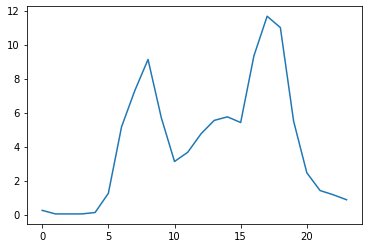

In [80]:
plt.plot(np.mean(lag_0[:,69].reshape(24,24), axis = 0)) # 6-10 am and 4-8 pm

In [81]:
# select those data in the mornning and evening rush hours
index_hour = []
for i in range (24): # 24days
    index_hour.append(np.arange(6,10) + 24*i)
    index_hour.append(np.arange(16,20) + 24*i)
index_hour = np.array(index_hour).flatten()
index_rush = []
for i in index_hour:
    index_rush.append(np.arange(i*100, (i+1)*100))
index_rush = np.array(index_rush).flatten()

# array form into dataframe
# OLS (coef estimates)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'lag_72', 
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_rush]
print(len(y))
X = bike_tripfactor_data[var_list].iloc[index_rush, :]

import statsmodels.api as sm

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

19200
                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     3075.
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:38:41   Log-Likelihood:                -46535.
No. Observations:               19200   AIC:                         9.310e+04
Df Residuals:                   19186   BIC:                         9.321e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3884    

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 7.425388479893615
Testing MSE: 7.607761301845658
Training r^2: 0.6802442419111081
Testing r^2: 0.6561501592211716

XGBoost:
Training MSE: 4.262545031361698
Testing MSE: 5.445830157239366
Training r^2: 0.8164441737180832
Testing r^2: 0.7538634878014622

MLP:
Training MSE: 5.4793441707679325
Testing MSE: 6.139937484812583
Training r^2: 0.7640457662386234
Testing r^2: 0.7224917498354501



In [83]:
# OLS (coef)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_rush]
X = bike_tripfactor_data[var_list].iloc[index_rush, :]

import statsmodels.api as sm

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     3345.
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:38:51   Log-Likelihood:                -45483.
No. Observations:               19200   AIC:                         9.100e+04
Df Residuals:                   19185   BIC:                         9.111e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3132      0.52

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=10)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 6.796077370172187
Testing MSE: 6.254870383005161
Training r^2: 0.7033455419967216
Testing r^2: 0.7324326765089404

XGBoost:
Training MSE: 4.160465820949644
Testing MSE: 4.963599821948001
Training r^2: 0.8183921892102134
Testing r^2: 0.7876699215306135

MLP:
Training MSE: 4.973665161908664
Testing MSE: 4.864370705776512
Training r^2: 0.7828953582295047
Testing r^2: 0.7919146887920628



In [85]:
# OLS (time + spatial + weather + graph)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'degree_24', 'pagerank_24', 'betweenness_24', 'degree_72', 'pagerank_72', 'betweenness_72',
            'degree_96', 'pagerank_96', 'betweenness_96', 'degree_120', 'pagerank_120', 'betweenness_120',
            'degree_144', 'pagerank_144', 'betweenness_144', 'degree_168', 'pagerank_168', 'betweenness_168',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_rush]
X = bike_tripfactor_data[var_list].iloc[index_rush, :]

import statsmodels.api as sm

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     1486.
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:39:01   Log-Likelihood:                -45370.
No. Observations:               19200   AIC:                         9.081e+04
Df Residuals:                   19167   BIC:                         9.107e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3529      0.52

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 6.565623901320086
Testing MSE: 6.7878057287923435
Training r^2: 0.7172678502171471
Testing r^2: 0.6932098909942618

XGBoost:
Training MSE: 4.016604508497538
Testing MSE: 5.463782044987945
Training r^2: 0.8270349863800941
Testing r^2: 0.7530521119578837

MLP:
Training MSE: 4.34208426262119
Testing MSE: 5.493395476112807
Training r^2: 0.8130190159289581
Testing r^2: 0.7517136664976235



In [87]:
# OLS (time + spatial + weather + public transit)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'metro_dnum_0', 'bus_dnum_0', 'bus_snum_0',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_rush]
X = bike_tripfactor_data[var_list].iloc[index_rush, :]

import statsmodels.api as sm

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     2764.
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:39:12   Log-Likelihood:                -45458.
No. Observations:               19200   AIC:                         9.095e+04
Df Residuals:                   19182   BIC:                         9.109e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3261      0.51

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 6.628885846038374
Testing MSE: 6.836624937272032
Training r^2: 0.7145436330066472
Testing r^2: 0.6910033973364472

XGBoost:
Training MSE: 3.9552452247698833
Testing MSE: 5.192473341939983
Training r^2: 0.8296772702602244
Testing r^2: 0.7653145174992249

MLP:
Training MSE: 4.55363349896802
Testing MSE: 5.5744182625734116
Training r^2: 0.8039091778882452
Testing r^2: 0.7480516598811466



In [89]:
# OLS (all features)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'degree_24', 'pagerank_24', 'betweenness_24', 'degree_72', 'pagerank_72', 'betweenness_72',
            'degree_96', 'pagerank_96', 'betweenness_96', 'degree_120', 'pagerank_120', 'betweenness_120',
            'degree_144', 'pagerank_144', 'betweenness_144', 'degree_168', 'pagerank_168', 'betweenness_168',
            'metro_dnum_0', 'bus_dnum_0', 'bus_snum_0',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_rush]
X = bike_tripfactor_data[var_list].iloc[index_rush, :]

import statsmodels.api as sm

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     1364.
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:39:22   Log-Likelihood:                -45344.
No. Observations:               19200   AIC:                         9.076e+04
Df Residuals:                   19164   BIC:                         9.104e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3782      0.52

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 6.5475903461378895
Testing MSE: 6.771370417791862
Training r^2: 0.7180444201062425
Testing r^2: 0.6939527217491246

XGBoost:
Training MSE: 3.9307745364873776
Testing MSE: 5.302249894181856
Training r^2: 0.8307310391645608
Testing r^2: 0.760352919926433

MLP:
Training MSE: 4.682679984314762
Testing MSE: 5.837952354971211
Training r^2: 0.7983521141921858
Testing r^2: 0.736140645311224



In [91]:
## ========================================================= Baseline Model =================================================##

In [92]:
# Hourly average (all data)

station_average_hourly = []
for i in range (lag_0.shape[1]):
    station_average_hourly.append(np.array(list(np.mean(lag_0[:, i].reshape((24,24)), axis = 1)) * 24))
station_average_hourly = np.array(station_average_hourly).T
print("HA MSE:", mean_squared_error(station_average_hourly.flatten(), lag_0.flatten()))
print("HA r_2:", r2_score(station_average_hourly.flatten(), lag_0.flatten()))

HA MSE: 15.568816550925927
HA r_2: -2.9261303470023172


In [93]:
# Hourly average (non-zero data)
lag_0_index = lag_0.copy()
station_average_hourly = []
for i in range (lag_0_index.shape[1]):
    for j in range (lag_0_index.shape[0]):
        if lag_0_index[j, i] == 0:
            lag_0_index[j, i] = np.nan
    station_average_hourly.append(np.array(list(np.nanmean(lag_0_index[:, i].reshape((24,24)), axis = 1)) * 24))
station_average_hourly = np.array(station_average_hourly).T.flatten()
lag_0_index = lag_0_index.flatten()
index_nonnan = []
for i in range (len(station_average_hourly)):
    if ~np.isnan(station_average_hourly[i]) and ~np.isnan(lag_0_index[i]):
        index_nonnan.append(i)
index_nonnan = np.array(index_nonnan)
print("HA MSE:", mean_squared_error(station_average_hourly[index_nonnan], lag_0_index[index_nonnan]))
print("HA r_2:", r2_score(station_average_hourly[index_nonnan], lag_0_index[index_nonnan]))

HA MSE: 24.788846107916992
HA r_2: -5.2179335332675185


In [94]:
# Hourly average (rush-hour data)

station_average_hourly = []

for i in range (lag_0.shape[1]):
    station_average_hourly.append(np.array(list(np.mean(lag_0[index_hour, i].reshape((8,24)), axis = 1)) * 24))
station_average_hourly = np.array(station_average_hourly).T
print("HA MSE:", mean_squared_error(station_average_hourly.flatten(), lag_0[index_hour, :].flatten()))
print("HA r_2:", r2_score(station_average_hourly.flatten(), lag_0[index_hour, :].flatten()))

HA MSE: 29.272903645833335
HA r_2: -1.6413825567065614


In [95]:
# ARIMA (all data)
from statsmodels.tsa.arima.model import ARIMA

arma_pred = []
for i in range (lag_0.shape[1]):
    data = lag_0[:, i]
    model = ARIMA(data, order=(6, 1, 1))  # Use an ARMA(6, 1) model
    result = model.fit()
    preds = result.predict(1, lag_0.shape[0])
    arma_pred.append(preds)
arma_pred = np.array(arma_pred).flatten()
print("ARMA MSE:", mean_squared_error(lag_0.flatten(), arma_pred))
print("ARMA r^2:",r2_score(lag_0.flatten(), arma_pred))

ARMA MSE: 19.96875492908718
ARMA r^2: -0.5764350980239119
